In [2]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
from datetime import datetime
import csv
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
plt.style.use('fivethirtyeight')
import warnings
from IPython.display import display_html
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.0f}'.format

In [2]:
df_ads = pd.read_csv("gs://aes-datahub-0001-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_DATASET_V8.4.csv")
df_ads = df_ads.loc[:, ~df_ads.columns.str.contains('^Unnamed')]

In [3]:
# CREATION_DATETIME
df_ads.head()

,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DOWNSTREAM_KVA_VAL,KVA_VAL,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,PRIM_OCCURN_DESC,SECO_OCCURN_DESC,TERT_OCCURN_DESC,PRIM_CAUSE_DESC,SECO_CAUSE_DESC,LAT,LONG,ZONE,LIVE_OUTAGE,UNIT,Min_Distance,Marker_Location,CLOUDCOVER,DEWPOINT,HUMIDITY,ICON,NEAREST-STATION,PRECIPINTENSITY,PRECIPINTENSITYMAX,PRECIPTYPE,PRESSURE,TEMPERATUREMAX,TEMPERATUREMIN,VISIBILITY,WINDBEARING,WINDGUST,WINDSPEED,clusters,Hour_Sin,Hour_Cos,MAJ_OTG_ID,STORM_END,STORM_START,RANK_SUBSEQUENT_OUTAGES
0,2001317842,2000391296,648-B/72,STORM,2007-02-24 20:02:00,2007-02-24 21:45:00,1702,ASWITCH,170,183,1282,4,2007-02-24 21:32:00,1282,6101,6101,0,103,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,INDIANAPOLIS,SUBSTATION,LOCK OUT,NaN,MISCELLANEOUS,NO CAUSE-PATROLLED,40,-86,2,8,nan,6,Marker12,1,19,1,snow,4,0,0,snow,1019,35,22,9,102,28,8,Cluster3.0,-1,0,20070001001,2007-02-24 22:49:02,2007-02-24 20:02:00,1
1,2001317865,2000391302,237--/42,STORM,2007-02-24 20:18:26,2007-02-24 21:50:00,1402,FUSE,140,2,4,0,2007-02-24 22:48:26,4,100,100,0,92,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,INDIANAPOLIS,FUSE,FUSE BLOWN,NaN,TREE,ON PRIMARY,40,-86,3,8,nan,5,Marker3,1,18,1,snow,2,0,0,snow,1019,35,23,9,103,27,7,Cluster3.0,-1,0,20070001001,2007-02-24 22:49:02,2007-02-24 20:02:00,2
2,2001317856,2000391313,M15-U/168,STORM,2007-02-24 20:31:55,2007-02-25 00:23:42,7001,1TBOH,700,1,1,0,2007-02-25 00:01:55,1,15,15,0,232,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,MONROVIA,FUSE,DEFECTIVE FUSE,NaN,MISCELLANEOUS,OTHER,40,-87,1,9,nan,2,Marker19,1,21,1,rain,11,0,0,rain,1018,38,24,9,101,24,8,Cluster7.0,-1,0,20070001001,2007-02-24 22:49:02,2007-02-24 20:02:00,3
3,2001317899,2000391321,495-A/106,STORM,2007-02-24 20:56:03,2007-02-25 00:30:00,1257,FUSE,125,133,271,2,2007-02-24 23:26:03,271,504,504,0,214,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,INDIANAPOLIS,FUSE,FUSE BLOWN,NaN,O.H. EQUIPMENT,BAD OR BROKEN INSULATOR,40,-86,4,10,nan,5,Marker11,1,19,1,snow,5,0,0,snow,1019,36,22,9,104,30,10,Cluster3.0,-1,0,20070001001,2007-02-24 22:49:02,2007-02-24 20:02:00,4
4,2001317873,2000391329,801QA/2,STORM,2007-02-24 20:59:10,2007-02-24 21:15:02,7056,FUSE,705,4,70,1,2007-02-24 23:29:10,70,870,870,0,16,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,MOORESVILLE,POLE BURNING,POLE BURNING,NaN,O.H. EQUIPMENT,BAD CUTOUT OR BARREL,40,-86,1,11,nan,6,Marker18,1,19,1,snow,12,0,0,snow,1019,36,22,9,104,27,9,Cluster3.0,-1,0,20070001001,2007-02-24 22:49:02,2007-02-24 20:02:00,5


In [4]:
df_ads['STORM_START'] = pd.to_datetime(df_ads['STORM_START'],errors='coerce')
df_ads['Date'] = df_ads['STORM_START'].dt.date
df_ads['Hour'] = df_ads['STORM_START'].dt.hour
df_ads['Date'] = pd.to_datetime(df_ads['Date'])
df_ads['CREATION_DATETIME'] = pd.to_datetime(df_ads['CREATION_DATETIME'],errors='coerce')
df_ads['RANK_SUBSEQUENT_OUTAGES'] = df_ads.groupby(['Date','Hour'])['CREATION_DATETIME'].rank(method='dense', ascending=True)

In [5]:
df_ads['CREATION_DATETIME'] = pd.to_datetime(df_ads['CREATION_DATETIME'],errors='coerce')
df_ads['RANK_SUBSEQUENT_MAJ_OTG_ID'] = df_ads.groupby(['MAJ_OTG_ID'],as_index=False)['CREATION_DATETIME'].rank(method='dense', ascending=True)

In [6]:
df_ads[['MAJ_OTG_ID','RANK_SUBSEQUENT_OUTAGES','RANK_SUBSEQUENT_MAJ_OTG_ID']]

,MAJ_OTG_ID,RANK_SUBSEQUENT_OUTAGES,RANK_SUBSEQUENT_MAJ_OTG_ID
0,20070001001,1,1
1,20070001001,2,2
2,20070001001,3,3
3,20070001001,4,4
4,20070001001,5,5
...,...,...,...
19668,20190013001,58,58
19669,20190013001,94,94
19670,20190013001,96,96
19671,20190013001,95,95


In [15]:
df_ads[df_ads['MAJ_OTG_ID']==20190013001][['MAJ_OTG_ID','RANK_SUBSEQUENT_OUTAGES','RANK_SUBSEQUENT_MAJ_OTG_ID','CREATION_DATETIME','Date','Hour']].sort_values(['RANK_SUBSEQUENT_MAJ_OTG_ID'],ascending=True)

,MAJ_OTG_ID,RANK_SUBSEQUENT_OUTAGES,RANK_SUBSEQUENT_MAJ_OTG_ID,CREATION_DATETIME,Date,Hour
19568,20190013001,1,1,2019-06-23 15:18:02,2019-06-23,15
19578,20190013001,2,2,2019-06-23 15:28:04,2019-06-23,15
19569,20190013001,3,3,2019-06-23 15:33:00,2019-06-23,15
19579,20190013001,4,4,2019-06-23 15:42:37,2019-06-23,15
19580,20190013001,4,4,2019-06-23 15:42:37,2019-06-23,15
19577,20190013001,5,5,2019-06-23 15:42:48,2019-06-23,15
19570,20190013001,6,6,2019-06-23 15:42:56,2019-06-23,15
19571,20190013001,7,7,2019-06-23 15:43:06,2019-06-23,15
19572,20190013001,8,8,2019-06-23 15:44:06,2019-06-23,15
19575,20190013001,9,9,2019-06-23 15:45:27,2019-06-23,15


In [23]:
m = df_ads.groupby(['RANK_SUBSEQUENT_MAJ_OTG_ID'],as_index=False).agg({'OUTAGE_ID': 'count'})
m.head()

,RANK_SUBSEQUENT_MAJ_OTG_ID,OUTAGE_ID
0,1.00,334
1,2.00,311
2,3.00,296
3,4.00,312
4,5.00,306


In [24]:
n = df_ads.groupby(['RANK_SUBSEQUENT_OUTAGES'],as_index=False).agg({'OUTAGE_ID': 'count'})
n.head()

,RANK_SUBSEQUENT_OUTAGES,OUTAGE_ID
0,1.00,334
1,2.00,311
2,3.00,296
3,4.00,312
4,5.00,306


In [30]:
print(df_ads['RANK_SUBSEQUENT_MAJ_OTG_ID'].nunique())
print(df_ads['RANK_SUBSEQUENT_OUTAGES'].nunique())

758
758


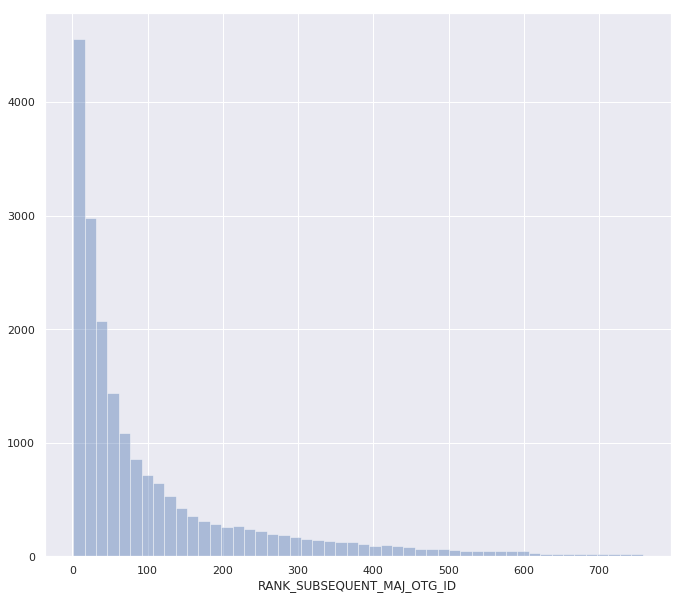

In [33]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(df_ads['RANK_SUBSEQUENT_MAJ_OTG_ID'],kde=False)

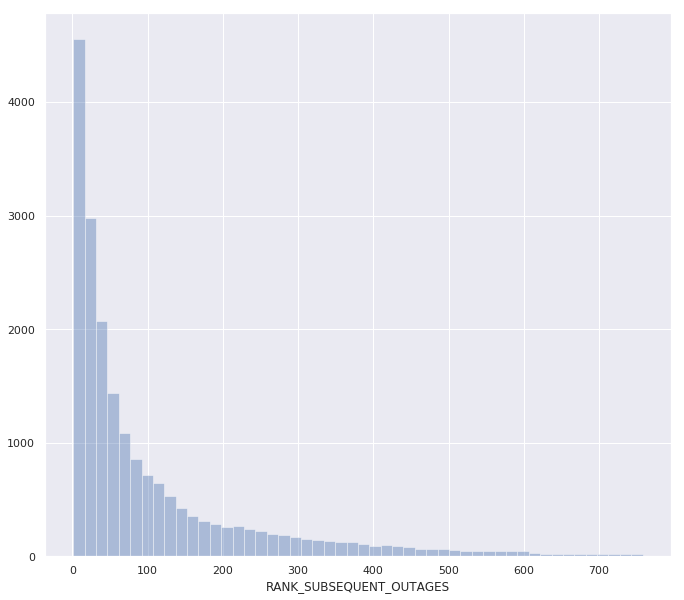

In [34]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(df_ads['RANK_SUBSEQUENT_OUTAGES'],kde=False)

In [3]:
d11_ua = pd.read_csv(r'gs://aes-datahub-0001-landing/CAD/IPL/CAD.D11_UNIT_ACTIVITY.csv', sep = ";", encoding = "ISO-8859-1")
d11_ua.head()
print(list(d11_ua.columns))

['AGENCY_CODE', 'UNIT', 'D11_START_DATETIME', 'B07_STATUS_CODE', 'ISR_NO', 'D11_END_DATETIME', 'D11_CAD_ACTION', 'S02_SHIFT_CODE', 'SHIFT_DATE', 'SERVICE_CODE', 'D11_CURRENT_LOC', 'C03S_ORIGIN', 'LONGITUDE', 'LATITUDE']


In [5]:
print(d11_ua.shape[0])
print(d11_ua.nunique())

19162197
AGENCY_CODE                  2
UNIT                       693
D11_START_DATETIME    14162591
B07_STATUS_CODE             10
ISR_NO                 2809965
D11_END_DATETIME      12599933
D11_CAD_ACTION              10
S02_SHIFT_CODE              13
SHIFT_DATE                2332
SERVICE_CODE               265
D11_CURRENT_LOC         693626
C03S_ORIGIN                 23
LONGITUDE                15560
LATITUDE                 15442
dtype: int64


In [41]:
d11_ua = d11_ua[d11_ua.AGENCY_CODE=='DIST.OPS']
d11_accepted = d11_ua[d11_ua.B07_STATUS_CODE=='AC']
d11_ac_start = d11_accepted.groupby(['ISR_NO'], as_index=False).agg({'D11_START_DATETIME' : 'min'})
del d11_accepted, d11_ua

In [42]:
del d11_ua

In [43]:
df_facility_job_his_raw = pd.read_csv('gs://aes-datahub-0001-landing/OMS/IPL/HIS_FACILITY_JOB.csv', sep = ";")
df_facility_job_his_raw = df_facility_job_his_raw[['FAC_JOB_ID','CAD_ID']]
ads = pd.merge(df_ads,df_facility_job_his_raw, how='left', left_on='OUTAGE_ID', right_on='FAC_JOB_ID', suffixes=('', '_y'))
ads = ads[ads.columns.drop(list(ads.filter(regex='_y')))]

del df_facility_job_his_raw

In [44]:
ads.head()

,Unnamed: 0,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DOWNSTREAM_KVA_VAL,KVA_VAL,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,PRIM_OCCURN_DESC,SECO_OCCURN_DESC,TERT_OCCURN_DESC,PRIM_CAUSE_DESC,SECO_CAUSE_DESC,LAT,LONG,ZONE,LIVE_OUTAGE,UNIT,Min_Distance,Marker_Location,CLOUDCOVER,DEWPOINT,HUMIDITY,ICON,NEAREST-STATION,PRECIPINTENSITY,PRECIPINTENSITYMAX,PRECIPTYPE,PRESSURE,TEMPERATUREMAX,TEMPERATUREMIN,VISIBILITY,WINDBEARING,WINDGUST,WINDSPEED,clusters,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,FAC_JOB_ID,CAD_ID
0,0,2001317842,2.000391e+09,648-B/72,STORM,2007-02-24 20:02:00,2007-02-24 21:45:00,1702.0,ASWITCH,170.0,183,1282.0,4.0,2007-02-24 21:32:00,1282.0,6101.333333,6101.333333,0,103.0000,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,INDIANAPOLIS,SUBSTATION,LOCK OUT,NaN,MISCELLANEOUS,NO CAUSE-PATROLLED,39.724871,-86.037147,2.0,8,NaN,6.274861,Marker12,0.68,18.68,0.68,snow,4.267,0.0214,0.1170,snow,1018.8,35.29,22.09,8.768,102.0,28.36,7.82,Cluster3.0,-0.866025,0.5,1.0,2001317842,NaN
1,1,2001317865,2.000391e+09,237--/42,STORM,2007-02-24 20:18:26,2007-02-24 21:50:00,1402.0,FUSE,140.0,2,4.0,0.0,2007-02-24 22:48:26,4.0,100.000000,100.000000,0,91.5667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,INDIANAPOLIS,FUSE,FUSE BLOWN,NaN,TREE,ON PRIMARY,39.896820,-86.145802,3.0,8,NaN,4.742901,Marker3,0.66,17.54,0.66,snow,2.018,0.0179,0.1055,snow,1018.8,34.77,22.61,8.793,103.0,26.63,7.23,Cluster3.0,-0.866025,0.5,1.0,2001317865,IPL-022407-000087
2,2,2001317856,2.000391e+09,M15-U/168,STORM,2007-02-24 20:31:55,2007-02-25 00:23:42,7001.0,1TBOH,700.0,1,1.0,0.0,2007-02-25 00:01:55,1.0,15.000000,15.000000,0,231.7833,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,MONROVIA,FUSE,DEFECTIVE FUSE,NaN,MISCELLANEOUS,OTHER,39.543034,-86.573913,1.0,9,NaN,1.898022,Marker19,0.69,20.93,0.70,rain,10.664,0.0324,0.1572,rain,1018.1,38.18,24.11,8.716,101.0,23.82,7.61,Cluster7.0,-0.866025,0.5,2.0,2001317856,IPL-022407-000091
3,3,2001317899,2.000391e+09,495-A/106,STORM,2007-02-24 20:56:03,2007-02-25 00:30:00,1257.0,FUSE,125.0,133,271.0,2.0,2007-02-24 23:26:03,271.0,503.666667,503.666667,0,213.9500,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,INDIANAPOLIS,FUSE,FUSE BLOWN,NaN,O.H. EQUIPMENT,BAD OR BROKEN INSULATOR,39.787152,-86.252024,4.0,10,NaN,4.946149,Marker11,0.70,18.60,0.67,snow,4.863,0.0235,0.1127,snow,1018.7,36.29,22.31,8.760,104.0,29.91,10.28,Cluster3.0,-0.866025,0.5,3.0,2001317899,IPL-022407-000090
4,4,2001317873,2.000391e+09,801QA/2,STORM,2007-02-24 20:59:10,2007-02-24 21:15:02,7056.0,FUSE,705.0,4,70.0,1.0,2007-02-24 23:29:10,70.0,870.000000,870.000000,0,15.8667,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,MOORESVILLE,POLE BURNING,POLE BURNING,

In [45]:
ads = ads[ads['CAD_ID'].notnull()]
print(ads.shape[0])

15954


In [46]:
merge_ads = pd.merge(ads, d11_ac_start, how='left', left_on='CAD_ID', right_on='ISR_NO', suffixes=('', '_y'))
merge_ads = merge_ads.loc[:, ~merge_ads.columns.str.contains('^Unnamed')]
print(merge_ads.shape[0])

15954


In [47]:
merge_ads.head()

,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DOWNSTREAM_KVA_VAL,KVA_VAL,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,PRIM_OCCURN_DESC,SECO_OCCURN_DESC,TERT_OCCURN_DESC,PRIM_CAUSE_DESC,SECO_CAUSE_DESC,LAT,LONG,ZONE,LIVE_OUTAGE,UNIT,Min_Distance,Marker_Location,CLOUDCOVER,DEWPOINT,HUMIDITY,ICON,NEAREST-STATION,PRECIPINTENSITY,PRECIPINTENSITYMAX,PRECIPTYPE,PRESSURE,TEMPERATUREMAX,TEMPERATUREMIN,VISIBILITY,WINDBEARING,WINDGUST,WINDSPEED,clusters,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,FAC_JOB_ID,CAD_ID,ISR_NO,D11_START_DATETIME
0,2001317865,2.000391e+09,237--/42,STORM,2007-02-24 20:18:26,2007-02-24 21:50:00,1402.0,FUSE,140.0,2,4.0,0.0,2007-02-24 22:48:26,4.0,100.000000,100.000000,0,91.5667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,INDIANAPOLIS,FUSE,FUSE BLOWN,NaN,TREE,ON PRIMARY,39.896820,-86.145802,3.0,8,NaN,4.742901,Marker3,0.66,17.54,0.66,snow,2.018,0.0179,0.1055,snow,1018.8,34.77,22.61,8.793,103.0,26.63,7.23,Cluster3.0,-0.866025,0.500000,1.0,2001317865,IPL-022407-000087,IPL-022407-000087,2007-02-24T21:27:43
1,2001317856,2.000391e+09,M15-U/168,STORM,2007-02-24 20:31:55,2007-02-25 00:23:42,7001.0,1TBOH,700.0,1,1.0,0.0,2007-02-25 00:01:55,1.0,15.000000,15.000000,0,231.7833,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,MONROVIA,FUSE,DEFECTIVE FUSE,NaN,MISCELLANEOUS,OTHER,39.543034,-86.573913,1.0,9,NaN,1.898022,Marker19,0.69,20.93,0.70,rain,10.664,0.0324,0.1572,rain,1018.1,38.18,24.11,8.716,101.0,23.82,7.61,Cluster7.0,-0.866025,0.500000,2.0,2001317856,IPL-022407-000091,IPL-022407-000091,2007-02-24T21:24:25
2,2001317899,2.000391e+09,495-A/106,STORM,2007-02-24 20:56:03,2007-02-25 00:30:00,1257.0,FUSE,125.0,133,271.0,2.0,2007-02-24 23:26:03,271.0,503.666667,503.666667,0,213.9500,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,INDIANAPOLIS,FUSE,FUSE BLOWN,NaN,O.H. EQUIPMENT,BAD OR BROKEN INSULATOR,39.787152,-86.252024,4.0,10,NaN,4.946149,Marker11,0.70,18.60,0.67,snow,4.863,0.0235,0.1127,snow,1018.7,36.29,22.31,8.760,104.0,29.91,10.28,Cluster3.0,-0.866025,0.500000,3.0,2001317899,IPL-022407-000090,IPL-022407-000090,2007-02-24T21:20:15
3,2001317927,2.000391e+09,130-B/25,STORM,2007-02-24 22:49:02,2007-02-25 00:45:25,2851.0,FUSE,285.0,8,16.0,0.0,2007-02-25 01:19:02,16.0,200.000000,200.000000,0,116.3833,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,CARMEL,FUSE,OPENED FOR SAFETY,NaN,WEATHER,WIND,39.940491,-86.212783,4.0,14,NaN,3.984837,Marker3,0.66,17.54,0.66,snow,2.018,0.0179,0.1055,snow,1018.8,34.77,22.61,8.793,103.0,26.63,7.23,Cluster3.0,-0.500000,0.866025,2.0,2001317927,IPL-022407-000110,IPL-022407-000110,2007-02-24T23:59:14
4,2001325290,2.000398e+09,596-A/87,STORM,2007-04-03 15:44:00,2007-04-03 18:10:00,8506.0,FUSE,850.0,13,49.0,0.0,NaN,49.0,300.000000,300.000000,1,146.0

In [48]:
merge_ads['CREATION_DATETIME'] = pd.to_datetime(merge_ads['CREATION_DATETIME'], errors='coerce')
merge_ads['Date'] = merge_ads['CREATION_DATETIME'].dt.date
merge_ads['Hour'] = merge_ads['CREATION_DATETIME'].dt.hour
merge_ads['D11_START_DATETIME'] = pd.to_datetime(merge_ads['D11_START_DATETIME'], errors='coerce')

In [49]:
merge_ads['D11_START_DATETIME'].isna().sum()

313

In [50]:
merge_ads = merge_ads[merge_ads['D11_START_DATETIME'].notnull()]

In [51]:
merge_ads['RANK_SUBSEQUENT_ACCEPTED'] = merge_ads.groupby(['Date','Hour'])['D11_START_DATETIME'].rank(method='dense', ascending=True)

In [52]:
merge_ads['RANK_SUBSEQUENT_ACCEPTED'].unique()

array([  3.,   2.,   1.,   4.,   5.,   6.,   8.,   7.,   9.,  10.,  11.,
        13.,  14.,  15.,  12.,  16.,  18.,  17.,  19.,  21.,  24.,  20.,
        22.,  23.,  27.,  26.,  25.,  28.,  29.,  30.,  31.,  38.,  54.,
        63.,  94.,  87.,  73.,  88.,  57.,  66.,  81.,  91.,  52.,  46.,
        64.,  80., 102.,  50.,  85.,  75.,  89., 103., 109.,  40.,  65.,
        72.,  99.,  47.,  48.,  84., 108., 105., 106.,  34.,  96.,  95.,
        76.,  78.,  56.,  98.,  45.,  83.,  43.,  69.,  33.,  77.,  86.,
       104.,  36.,  92.,  35.,  53.,  59.,  68., 107.,  44.,  41.,  37.,
        71.,  61.,  51.,  70.,  62., 101.,  79.,  67.,  58.,  32.,  49.,
        42.,  93.,  39.,  55.,  60.,  90.,  82.,  74.,  97., 100., 110.,
       111., 136., 132., 135., 125., 122., 114., 115., 130., 120., 131.,
       137., 126., 112., 113., 133., 121., 119., 129., 127., 118., 124.,
       117., 123., 116., 128., 134., 149., 138., 144., 143., 141., 150.,
       154., 158., 146., 161., 151., 142., 153., 14

In [61]:
m = merge_ads.groupby(['RANK_SUBSEQUENT_ACCEPTED'],as_index=False).agg({'OUTAGE_ID': 'count'})
m.head()

,RANK_SUBSEQUENT_ACCEPTED,OUTAGE_ID
0,1.0,3458
1,2.0,2262
2,3.0,1518
3,4.0,1090
4,5.0,799


In [62]:
n = merge_ads.groupby(['RANK_SUBSEQUENT_OUTAGES'],as_index=False).agg({'OUTAGE_ID': 'count'})
n.head()

,RANK_SUBSEQUENT_OUTAGES,OUTAGE_ID
0,1.0,3697
1,2.0,2560
2,3.0,1602
3,4.0,951
4,5.0,675


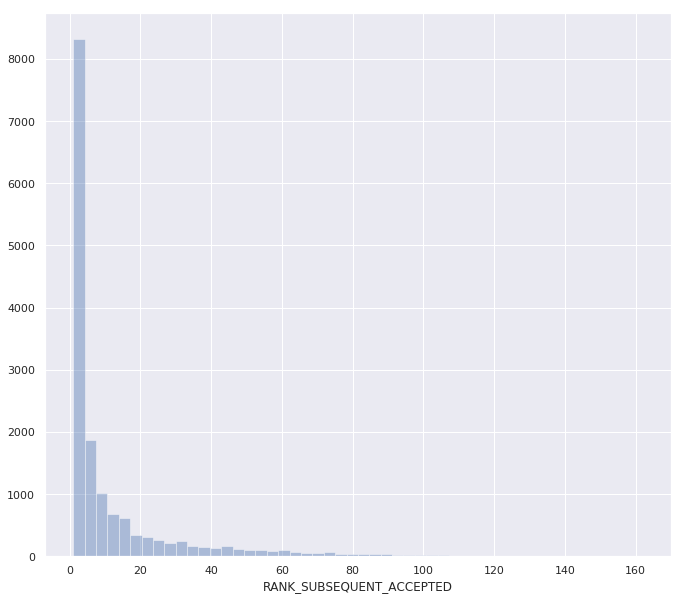

In [57]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(merge_ads['RANK_SUBSEQUENT_ACCEPTED'],kde=False)

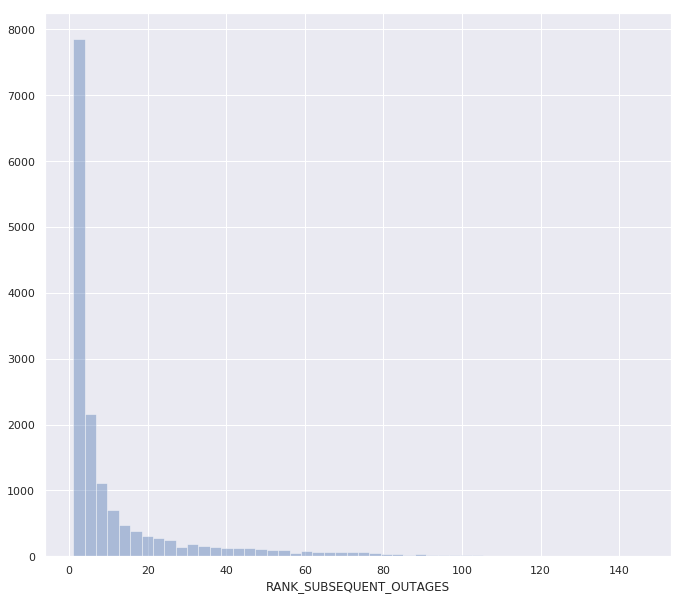

In [56]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(merge_ads['RANK_SUBSEQUENT_OUTAGES'],kde=False)